# Prediction of bookings based on user behavior
Data Scientist – User Profiling, Hotel Search

- Author: Kai Chen
- Date: Apr, 2018

There are 3 types of data: Bookings, User actions, Example

## Data: Bookings
- Description: List of sessions, each with: session-related contextual data, and whether at least one booking was made
- Files:
	- case_study_bookings_train.csv: Training sessions for bookings
	- case_study_bookings_target.csv: Target sessions to predict bookings
- Rows: Each row represents a session with session context and the outcome of this session
- Columns:
	- ymd: Date of the session in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- referer_code: Encoded category of the referer to the website
	- is_app: If the session was made using the trivago app
	- agent_id: Encoded type of the browser
	- traffic_type: A categorization of the type of the traffic
	- has_booking: 1 if at least one booking was made during the session (excluded from the target set)
    
## Data: User Actions
- Description: Sequence of various type of user actions generated during the usage of the website.
- Files
	- case_study_actions_train.csv: Training set of user actions
	- case_study_actions_target.csv: User actions in the target sessions
- Rows: Each row represents one action from/to the user
- Columns:
	- ymd: Date of the action in format 'yyMMdd'
	- user_id: Anonymized cookie id of the visitor
	- session_id: Anonymized id of the session
	- action_id: Type of the action
	- reference: Object of the action. - We note that action_ids with big set of reference values (e.g. action id '2116') are typically related to the content (e.g hotels, destinations or keywords); while action_ids with small reference set (e.g. action id '2351') are more related a function of the website (e.g. sorting order, room type, filters, etc.)
	- step: The number identifying the action in the session
	
## Data: Example Solution
- Description: List of predictions for bookings in the target sessions
- File: case_study_bookings_target_prediction_example.csv
- Rows: Each row represent a target session for which a prediction should be given
- Columns:
	- session_id: Anonymized id of the session
	- has_booking: Random binary predictions for bookings

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

import numpy as np
import pandas as pd
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn import linear_model

import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
# ---
# Define file paths
TRAIN_BOOKING_FILE_PATH = 'data/case_study_bookings_train.csv'    # training sessions for bookings
TARGET_BOOKING_FILE_PATH = 'data/case_study_bookings_target.csv'  # target sessions to predict bookings

TRAIN_ACTION_FILE_PATH = 'data/case_study_actions_train.csv'       # training set of user actions
TARGET_ACTION_FILE_PATH = 'data/case_study_actions_target.csv'     # user actions in the target sessions

## Step 1: read and explore the data

In [5]:
train_booking_df = pd.read_csv(TRAIN_BOOKING_FILE_PATH, sep='\t')
train_booking_df['ymd'] = pd.to_datetime(train_booking_df['ymd'].astype('str'))

print('train booking')
print(train_booking_df.columns)
display(train_booking_df.head(5))

train booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'has_booking'],
      dtype='object')


ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-23   388309106223940  3052767322364990735             0       0   
1 2017-04-10   452426828488840  1022778951418899936             0       0   
2 2017-04-15   452426828488840  4191504489082712531             0       0   
3 2017-04-06   819438352219100  4560227804862289210             1       0   
4 2017-04-07  1113732603712480  4115013282086590434             0       0   

   agent_id  traffic_type  has_booking  
0         2             1            0  
1        10             2            0  
2        10             2            0  
3         1             1            0  
4         9             2            0

In [6]:
target_booking_df = pd.read_csv(TARGET_BOOKING_FILE_PATH, sep='\t')
target_booking_df['ymd'] = pd.to_datetime(target_booking_df['ymd'].astype('str'))

print('target booking')
print(target_booking_df.columns)
display(target_booking_df.head(5))

target booking
Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type'],
      dtype='object')


ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-30  1607565913119260  4175939893794521966             0       0   
1 2017-04-30  1607565913119260  9175174925268392332             0       0   
2 2017-04-30  2669945826129900  5361965966177226983             0       0   
3 2017-04-30  6247954936827660  7996347049132178025             0       0   
4 2017-04-30  6447705595982360  6061498713259551906            99       0   

   agent_id  traffic_type  
0        14             6  
1        14             1  
2         6             6  
3        13             2  
4         1             6

In [7]:
train_user_id_list = train_booking_df['user_id'].unique()
train_session_id_list = train_booking_df['session_id'].unique()

print('number of users (train booking data): {}'.format(len(train_user_id_list)))
print('number of sessions (tarin booking data): {}'.format(len(train_session_id_list)))
print('dataframe size (train booking data)')
print(train_booking_df.shape)

number of users (train booking data): 181860
number of sessions (tarin booking data): 307677
dataframe size (train booking data)
(307677, 8)


In [8]:
target_user_id_list = target_booking_df['user_id'].unique()
target_session_id_list = target_booking_df['session_id'].unique()

print('number of users (target booking data): {}'.format(len(target_user_id_list)))
print('number of sessions (target booking data): {}'.format(len(target_session_id_list)))
print('dataframe size (target booking data)')
print(target_booking_df.shape)

number of users (target booking data): 23402
number of sessions (target booking data): 30128
dataframe size (target booking data)
(30128, 7)


In [9]:
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

print('train action')
print(train_action_df.columns)
display(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')


ymd          user_id           session_id  action_id  reference  step
0 2017-04-23  388309106223940  3052767322364990735       8001    1323836     1
1 2017-04-10  452426828488840  1022778951418899936       2116     929835     1
2 2017-04-10  452426828488840  1022778951418899936       6999          0     2
3 2017-04-10  452426828488840  1022778951418899936       2116     929835     3
4 2017-04-10  452426828488840  1022778951418899936       2503          1     4

In [10]:
train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()

print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data)')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data)
(5862863, 6)


In [11]:
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  4175939893794521966       6999          0   
2 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
3 2017-04-30  1607565913119260  9175174925268392332       2100          0   
4 2017-04-30  1607565913119260  9175174925268392332       6999          0   

   step  
0     1  
1     2  
2     3  
3     1  
4     2  


In [12]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()


print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data)')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data)
(575152, 6)


In [13]:
train_action_df = pd.read_csv(TRAIN_ACTION_FILE_PATH, sep='\t')
train_action_df['ymd'] = pd.to_datetime(train_action_df['ymd'].astype('str'))

print('train action')
print(train_action_df.columns)
print(train_action_df.head(5))

train action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd          user_id           session_id  action_id  reference  step
0 2017-04-23  388309106223940  3052767322364990735       8001    1323836     1
1 2017-04-10  452426828488840  1022778951418899936       2116     929835     1
2 2017-04-10  452426828488840  1022778951418899936       6999          0     2
3 2017-04-10  452426828488840  1022778951418899936       2116     929835     3
4 2017-04-10  452426828488840  1022778951418899936       2503          1     4


In [14]:
train_user_id_action_list = train_action_df['user_id'].unique()
train_session_id_action_list = train_action_df['session_id'].unique()


print('number of users (train action data): {}'.format(len(train_user_id_action_list)))
print('number of sessions (train action data): {}'.format(len(train_session_id_action_list)))
print('dataframe size (train booking data)')
print(train_action_df.shape)

number of users (train action data): 181730
number of sessions (train action data): 306106
dataframe size (train booking data)
(5862863, 6)


In [15]:
target_action_df = pd.read_csv(TARGET_ACTION_FILE_PATH, sep='\t')
target_action_df['ymd'] = pd.to_datetime(target_action_df['ymd'].astype('str'))

print('target action')
print(target_action_df.columns)
print(target_action_df.head(5))

target action
Index(['ymd', 'user_id', 'session_id', 'action_id', 'reference', 'step'], dtype='object')
         ymd           user_id           session_id  action_id  reference  \
0 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
1 2017-04-30  1607565913119260  4175939893794521966       6999          0   
2 2017-04-30  1607565913119260  4175939893794521966       2113      60196   
3 2017-04-30  1607565913119260  9175174925268392332       2100          0   
4 2017-04-30  1607565913119260  9175174925268392332       6999          0   

   step  
0     1  
1     2  
2     3  
3     1  
4     2  


In [16]:
target_user_id_action_list = target_action_df['user_id'].unique()
target_session_id_action_list = target_action_df['session_id'].unique()


print('number of users (target action data): {}'.format(len(target_user_id_action_list)))
print('number of sessions (target action data): {}'.format(len(target_session_id_action_list)))
print('dataframe size (target booking data)')
print(target_action_df.shape)

number of users (target action data): 23314
number of sessions (target action data): 29957
dataframe size (target booking data)
(575152, 6)


In [17]:
train_user_df =  pd.merge(train_booking_df, train_action_df, on=['ymd', 'user_id', 'session_id'])
print('train user df shape')
print(train_user_df.shape)
display(train_user_df.head(5))

train user df shape
(5862863, 11)


ymd          user_id           session_id  referer_code  is_app  \
0 2017-04-23  388309106223940  3052767322364990735             0       0   
1 2017-04-10  452426828488840  1022778951418899936             0       0   
2 2017-04-10  452426828488840  1022778951418899936             0       0   
3 2017-04-10  452426828488840  1022778951418899936             0       0   
4 2017-04-10  452426828488840  1022778951418899936             0       0   

   agent_id  traffic_type  has_booking  action_id  reference  step  
0         2             1            0       8001    1323836     1  
1        10             2            0       2116     929835     1  
2        10             2            0       6999          0     2  
3        10             2            0       2116     929835     3  
4        10             2            0       2503          1     4

In [18]:
print('ymd (train)')
print(train_user_df['ymd'].unique())

ymd (train)
['2017-04-23T00:00:00.000000000' '2017-04-10T00:00:00.000000000'
 '2017-04-15T00:00:00.000000000' '2017-04-06T00:00:00.000000000'
 '2017-04-07T00:00:00.000000000' '2017-04-19T00:00:00.000000000'
 '2017-04-16T00:00:00.000000000' '2017-04-17T00:00:00.000000000'
 '2017-04-04T00:00:00.000000000' '2017-04-13T00:00:00.000000000'
 '2017-04-08T00:00:00.000000000' '2017-04-25T00:00:00.000000000'
 '2017-04-09T00:00:00.000000000' '2017-04-12T00:00:00.000000000'
 '2017-04-03T00:00:00.000000000' '2017-04-24T00:00:00.000000000'
 '2017-04-27T00:00:00.000000000' '2017-04-26T00:00:00.000000000'
 '2017-04-02T00:00:00.000000000' '2017-04-14T00:00:00.000000000'
 '2017-04-05T00:00:00.000000000' '2017-04-22T00:00:00.000000000'
 '2017-04-20T00:00:00.000000000' '2017-04-11T00:00:00.000000000'
 '2017-04-18T00:00:00.000000000' '2017-04-21T00:00:00.000000000'
 '2017-04-01T00:00:00.000000000']


In [19]:
target_user_df =  pd.merge(target_booking_df, target_action_df, on=['ymd', 'user_id', 'session_id'])
print('target user df shape')
print(target_user_df.shape)

target user df shape
(575152, 10)


In [20]:
print(target_user_df.columns)
print(target_user_df.head(5))
print('ymd (target)')
print(target_user_df['ymd'].unique())

Index(['ymd', 'user_id', 'session_id', 'referer_code', 'is_app', 'agent_id',
       'traffic_type', 'action_id', 'reference', 'step'],
      dtype='object')
         ymd           user_id           session_id  referer_code  is_app  \
0 2017-04-30  1607565913119260  4175939893794521966             0       0   
1 2017-04-30  1607565913119260  4175939893794521966             0       0   
2 2017-04-30  1607565913119260  4175939893794521966             0       0   
3 2017-04-30  1607565913119260  9175174925268392332             0       0   
4 2017-04-30  1607565913119260  9175174925268392332             0       0   

   agent_id  traffic_type  action_id  reference  step  
0        14             6       2113      60196     1  
1        14             6       6999          0     2  
2        14             6       2113      60196     3  
3        14             1       2100          0     1  
4        14             1       6999          0     2  
ymd (target)
['2017-04-30T00:00:00.000000000

In [22]:
train_user_id_list = train_user_df['user_id'].unique()

print('number of users (train) {}'.format(len(train_user_id_list)))

number of users (train) 181730


In [23]:
target_user_id_list = target_user_df['user_id'].unique()

print('number of users (target) {}'.format(len(target_user_id_list)))

number of users (target) 23314


In [27]:
print('\nnumber of different user between train user id and target user id')
print(len(set(train_user_id_list) - set(target_user_id_list)))

# this shows that we can not use user_id as a feature


number of different user between train user id and target user id
173755


In [29]:
print('correlation')
corr_score = train_user_df['referer_code'].corr(train_user_df['has_booking'])
print('corr score of referer_code and has_booking {}'.format(corr_score))

corr_score = train_user_df['is_app'].corr(train_user_df['has_booking'])
print('corr score of is_app and has_booking {}'.format(corr_score))

corr_score = train_user_df['agent_id'].corr(train_user_df['has_booking'])
print('corr score of agent_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['traffic_type'].corr(train_user_df['has_booking'])
print('corr score of traffic_type and has_booking {}'.format(corr_score))

corr_score = train_user_df['action_id'].corr(train_user_df['has_booking'])
print('corr score of action_id and has_booking {}'.format(corr_score))

corr_score = train_user_df['reference'].corr(train_user_df['has_booking'])
print('corr score of reference and has_booking {}'.format(corr_score))

corr_score = train_user_df['step'].corr(train_user_df['has_booking'])
print('corr score of step and has_booking {}'.format(corr_score))

correlation
corr score of referer_code and has_booking -0.04996365727616134
corr score of is_app and has_booking -0.05034281311524376
corr score of agent_id and has_booking -0.1027644482553173
corr score of traffic_type and has_booking -0.08003718320445342
corr score of action_id and has_booking 0.008564912707614244
corr score of reference and has_booking 0.005837510233315804
corr score of step and has_booking 0.08539763680890129


In [32]:
def get_nb_bookings_dict(df, column_name, has_booking_name='has_booking'):
    # key: column value  value: number of bookings
    dict_nb_bookings = dict()
    col_list = df[column_name].unique()
    # print(column_name)
    # print(col_list)
    for value in col_list:
        values = df[train_user_df[column_name] == value][has_booking_name].values
        dict_nb_bookings[value] = sum(values)

    return dict_nb_bookings, col_list

In [33]:
feature_columns = ['referer_code', 'is_app', 'agent_id', 'traffic_type', 'action_id', 'reference', 'step']
dict_feature_nb_bookings = dict()
dict_feature_list = dict()

for feature_column in feature_columns:
    dict_feature_column, feature_column_list = get_nb_bookings_dict(train_user_df, feature_column)
    
    dict_feature_nb_bookings[feature_column] = dict_feature_column
    dict_feature_list[feature_column] = feature_column_list
    
    print('\n --------------------')
    print(feature_column)
    print(feature_column_list)
    for code, nb in dict_feature_column.items():
        print('{}: {} #bookings: {}'.format(feature_column, code, nb))
    print('\n --------------------\n')


 --------------------
referer_code
[ 0  1 99 15 11 10 24 21 23 17 19]
referer_code: 0 #bookings: 308655
referer_code: 1 #bookings: 366608
referer_code: 99 #bookings: 43789
referer_code: 15 #bookings: 1297
referer_code: 11 #bookings: 29141
referer_code: 10 #bookings: 10611
referer_code: 24 #bookings: 0
referer_code: 21 #bookings: 1785
referer_code: 23 #bookings: 402
referer_code: 17 #bookings: 21
referer_code: 19 #bookings: 0

 --------------------


 --------------------
is_app
[0 1]
is_app: 0 #bookings: 700019
is_app: 1 #bookings: 62290

 --------------------


 --------------------
agent_id
[ 2 10  1  9 14  7  8  6 13  0 12 11  3  4  5]
agent_id: 2 #bookings: 33809
agent_id: 10 #bookings: 78428
agent_id: 1 #bookings: 224860
agent_id: 9 #bookings: 128684
agent_id: 14 #bookings: 41493
agent_id: 7 #bookings: 69655
agent_id: 8 #bookings: 100821
agent_id: 6 #bookings: 57062
agent_id: 13 #bookings: 22576
agent_id: 0 #bookings: 2848
agent_id: 12 #bookings: 711
agent_id: 11 #bookings: 1354



 --------------------
reference
[ 1323836   929835        0 ...     4458     4848 33477474]
reference: 1323836 #bookings: 0
reference: 929835 #bookings: 0
reference: 0 #bookings: 105519
reference: 1 #bookings: 63900
reference: 447485 #bookings: 93
reference: 41492 #bookings: 1206
reference: 19003 #bookings: 24
reference: 19011 #bookings: 4
reference: 18987 #bookings: 47
reference: 7 #bookings: 1797
reference: 3 #bookings: 9113
reference: 262144 #bookings: 5192
reference: 219033 #bookings: 0
reference: 40 #bookings: 2075
reference: 19006 #bookings: 31
reference: 19033 #bookings: 51
reference: 50 #bookings: 1452
reference: 404053 #bookings: 641
reference: 60 #bookings: 10623
reference: 412 #bookings: 1948
reference: 212 #bookings: 6476
reference: 1276668 #bookings: 0
reference: 133783 #bookings: 0
reference: 6 #bookings: 10946
reference: 65536 #bookings: 7178
reference: 359221 #bookings: 0
reference: 944775 #bookings: 0
reference: 41 #bookings: 1560
reference: 34390 #bookings: 52
refere

reference: 909485 #bookings: 6
reference: 163359 #bookings: 11
reference: 21623 #bookings: 0
reference: 1208406 #bookings: 0
reference: 3976966 #bookings: 5
reference: 530338 #bookings: 38
reference: 6802238 #bookings: 1
reference: 530208 #bookings: 1
reference: 1334852 #bookings: 1
reference: 757396 #bookings: 2
reference: 3924454 #bookings: 6
reference: 945337 #bookings: 5
reference: 44232 #bookings: 327
reference: 4942 #bookings: 4
reference: 35543 #bookings: 2
reference: 39362 #bookings: 152
reference: 19768 #bookings: 76
reference: 1216780 #bookings: 47
reference: 89468 #bookings: 5
reference: 1487915 #bookings: 65
reference: 4636720 #bookings: 12
reference: 19411 #bookings: 13
reference: 19401 #bookings: 27
reference: 48053 #bookings: 14
reference: 719411 #bookings: 3
reference: 558040 #bookings: 2
reference: 46274 #bookings: 1
reference: 1147875 #bookings: 0
reference: 18718 #bookings: 64
reference: 47174 #bookings: 43
reference: 1362578 #bookings: 1
reference: 558042 #bookings:

reference: 958757 #bookings: 0
reference: 39602 #bookings: 12
reference: 47635 #bookings: 0
reference: 490269 #bookings: 17
reference: 1750811 #bookings: 0
reference: 84866 #bookings: 100
reference: 2081670 #bookings: 0
reference: 533836 #bookings: 2
reference: 162864 #bookings: 0
reference: 149698 #bookings: 1
reference: 15656 #bookings: 1
reference: 67379 #bookings: 0
reference: 3994898 #bookings: 0
reference: 46501 #bookings: 11
reference: 951495 #bookings: 0
reference: 557566 #bookings: 2
reference: 2044975 #bookings: 8
reference: 6849182 #bookings: 0
reference: 47933 #bookings: 9
reference: 553166 #bookings: 7
reference: 48166 #bookings: 74
reference: 47373 #bookings: 9
reference: 47799 #bookings: 13
reference: 18426 #bookings: 6
reference: 148510 #bookings: 0
reference: 55354 #bookings: 0
reference: 342896 #bookings: 0
reference: 40587 #bookings: 174
reference: 12595 #bookings: 82
reference: 533871 #bookings: 30
reference: 44675 #bookings: 25
reference: 2671048 #bookings: 0
refer

reference: 46239 #bookings: 3
reference: 342316 #bookings: 3
reference: 46451 #bookings: 153
reference: 4497988 #bookings: 6
reference: 149136 #bookings: 75
reference: 1038018 #bookings: 2
reference: 3768494 #bookings: 8
reference: 1167758 #bookings: 13
reference: 1169960 #bookings: 37
reference: 967771 #bookings: 1
reference: 46243 #bookings: 2
reference: 1074950 #bookings: 1
reference: 1007887 #bookings: 0
reference: 71007887 #bookings: 0
reference: 47065 #bookings: 96
reference: 1358401 #bookings: 9
reference: 137696 #bookings: 12
reference: 235754 #bookings: 0
reference: 11528 #bookings: 1
reference: 14186 #bookings: 1
reference: 17769 #bookings: 3
reference: 15111 #bookings: 1
reference: 17423 #bookings: 0
reference: 2627705 #bookings: 0
reference: 2159030 #bookings: 10
reference: 149075 #bookings: 3
reference: 1574603 #bookings: 1
reference: 46303 #bookings: 4
reference: 1840085 #bookings: 7
reference: 18420 #bookings: 6
reference: 4455144 #bookings: 20
reference: 18447 #bookings

reference: 1439509 #bookings: 4
reference: 2174680 #bookings: 1
reference: 119578 #bookings: 11
reference: 5027294 #bookings: 2
reference: 2786334 #bookings: 1
reference: 1074760 #bookings: 3
reference: 364766 #bookings: 40
reference: 947157 #bookings: 1
reference: 634806 #bookings: 11
reference: 945451 #bookings: 33
reference: 47817 #bookings: 34
reference: 12762 #bookings: 74
reference: 1858183 #bookings: 3
reference: 1215004 #bookings: 0
reference: 39415 #bookings: 4
reference: 1991685 #bookings: 64
reference: 151579 #bookings: 0
reference: 218041 #bookings: 0
reference: 412706 #bookings: 0
reference: 95949 #bookings: 1
reference: 126815 #bookings: 0
reference: 117361 #bookings: 2
reference: 1478587 #bookings: 10
reference: 89096 #bookings: 0
reference: 124532 #bookings: 0
reference: 1158832 #bookings: 0
reference: 48185 #bookings: 0
reference: 2709274 #bookings: 1
reference: 4060116 #bookings: 0
reference: 1105940 #bookings: 0
reference: 43253 #bookings: 6
reference: 106038 #bookin

reference: 5742820 #bookings: 0
reference: 150441 #bookings: 0
reference: 7469 #bookings: 1
reference: 148320 #bookings: 59
reference: 2045293 #bookings: 3
reference: 128598 #bookings: 0
reference: 3981202 #bookings: 0
reference: 91407 #bookings: 0
reference: 48040 #bookings: 40
reference: 2670680 #bookings: 0
reference: 133089 #bookings: 6
reference: 1322526 #bookings: 0
reference: 39024 #bookings: 12
reference: 4763864 #bookings: 13
reference: 632796 #bookings: 4
reference: 5607064 #bookings: 0
reference: 164220 #bookings: 26
reference: 6695866 #bookings: 11
reference: 3133853 #bookings: 7
reference: 1259691 #bookings: 2
reference: 913329 #bookings: 0
reference: 31660 #bookings: 17
reference: 37936 #bookings: 21
reference: 34717 #bookings: 3
reference: 322751 #bookings: 2
reference: 31817925 #bookings: 0
reference: 19313 #bookings: 49
reference: 42275 #bookings: 10
reference: 84767 #bookings: 0
reference: 436511 #bookings: 0
reference: 684276 #bookings: 0
reference: 73272 #bookings: 

reference: 1112545 #bookings: 6
reference: 1487727 #bookings: 0
reference: 156581 #bookings: 26
reference: 2276268 #bookings: 0
reference: 4483316 #bookings: 1
reference: 940296 #bookings: 0
reference: 4078962 #bookings: 0
reference: 633696 #bookings: 4
reference: 366851 #bookings: 0
reference: 1142629 #bookings: 17
reference: 1892661 #bookings: 0
reference: 1815727 #bookings: 0
reference: 3900396 #bookings: 0
reference: 4130904 #bookings: 0
reference: 2143858 #bookings: 0
reference: 4569674 #bookings: 0
reference: 5779292 #bookings: 0
reference: 5067054 #bookings: 0
reference: 4982934 #bookings: 0
reference: 40836 #bookings: 2
reference: 6693478 #bookings: 0
reference: 2898788 #bookings: 0
reference: 36708 #bookings: 33
reference: 4754580 #bookings: 0
reference: 188141 #bookings: 1
reference: 4639790 #bookings: 0
reference: 49421 #bookings: 4
reference: 4597906 #bookings: 0
reference: 114338 #bookings: 0
reference: 150653 #bookings: 16
reference: 3976962 #bookings: 0
reference: 130320

reference: 685111 #bookings: 0
reference: 7685111 #bookings: 0
reference: 2655526 #bookings: 0
reference: 72655526 #bookings: 0
reference: 1166431 #bookings: 0
reference: 2333144 #bookings: 0
reference: 12813 #bookings: 0
reference: 1825377 #bookings: 0
reference: 31478 #bookings: 12
reference: 3086743 #bookings: 0
reference: 41874 #bookings: 0
reference: 41854 #bookings: 0
reference: 85432 #bookings: 0
reference: 775863 #bookings: 0
reference: 42000 #bookings: 0
reference: 3175572 #bookings: 0
reference: 100556 #bookings: 0
reference: 100574 #bookings: 0
reference: 919253 #bookings: 0
reference: 384721 #bookings: 0
reference: 518936 #bookings: 0
reference: 505706 #bookings: 0
reference: 48000 #bookings: 32
reference: 52606 #bookings: 0
reference: 1638935 #bookings: 0
reference: 3385358 #bookings: 0
reference: 6312378 #bookings: 0
reference: 4545600 #bookings: 0
reference: 5163500 #bookings: 0
reference: 5796634 #bookings: 0
reference: 4055884 #bookings: 0
reference: 17631 #bookings: 1

reference: 489826 #bookings: 0
reference: 2870168 #bookings: 0
reference: 1285953 #bookings: 0
reference: 631376 #bookings: 1
reference: 342476 #bookings: 10
reference: 86918 #bookings: 1
reference: 1239902 #bookings: 49
reference: 38290 #bookings: 35
reference: 19705 #bookings: 4
reference: 1571087 #bookings: 0
reference: 71853 #bookings: 33
reference: 6111548 #bookings: 0
reference: 1220044 #bookings: 0
reference: 1946849 #bookings: 0
reference: 4073378 #bookings: 0
reference: 2196296 #bookings: 3
reference: 1823451 #bookings: 1
reference: 2339712 #bookings: 3
reference: 922527 #bookings: 1
reference: 1839567 #bookings: 0
reference: 2061568 #bookings: 0
reference: 2149442 #bookings: 0
reference: 7574 #bookings: 0
reference: 82400 #bookings: 0
reference: 1998221 #bookings: 6
reference: 1602591 #bookings: 0
reference: 636561 #bookings: 1
reference: 94292 #bookings: 0
reference: 94245 #bookings: 0
reference: 41210 #bookings: 14
reference: 41108 #bookings: 13
reference: 2419834 #bookings

reference: 85717 #bookings: 2
reference: 6866 #bookings: 1
reference: 361821 #bookings: 0
reference: 3135292 #bookings: 0
reference: 85740 #bookings: 13
reference: 5624 #bookings: 0
reference: 51221 #bookings: 0
reference: 632331 #bookings: 16
reference: 1936353 #bookings: 29
reference: 14088 #bookings: 9
reference: 100023 #bookings: 9
reference: 111265 #bookings: 2
reference: 112522 #bookings: 6
reference: 13323 #bookings: 6
reference: 2254426 #bookings: 48
reference: 2782310 #bookings: 0
reference: 163076 #bookings: 0
reference: 15736 #bookings: 57
reference: 15941 #bookings: 1
reference: 43282 #bookings: 1
reference: 624276 #bookings: 1
reference: 4991172 #bookings: 3
reference: 6152 #bookings: 0
reference: 46774 #bookings: 2
reference: 1138341 #bookings: 0
reference: 2790622 #bookings: 0
reference: 1196618 #bookings: 0
reference: 18780 #bookings: 2
reference: 342481 #bookings: 20
reference: 1078748 #bookings: 0
reference: 343546 #bookings: 0
reference: 46480 #bookings: 0
reference:

reference: 2074416 #bookings: 0
reference: 447861 #bookings: 0
reference: 4946276 #bookings: 1
reference: 488347 #bookings: 15
reference: 533236 #bookings: 0
reference: 2327148 #bookings: 0
reference: 42044 #bookings: 10
reference: 131637 #bookings: 13
reference: 153267 #bookings: 0
reference: 1076336 #bookings: 0
reference: 1942573 #bookings: 13
reference: 1576213 #bookings: 0
reference: 781689 #bookings: 0
reference: 5760108 #bookings: 0
reference: 742976 #bookings: 0
reference: 516944 #bookings: 0
reference: 6007146 #bookings: 0
reference: 6916872 #bookings: 0
reference: 6507002 #bookings: 0
reference: 7015448 #bookings: 0
reference: 1320839 #bookings: 8
reference: 4735280 #bookings: 3
reference: 118459 #bookings: 7
reference: 6578912 #bookings: 0
reference: 4126792 #bookings: 0
reference: 638731 #bookings: 3
reference: 42106 #bookings: 9
reference: 3088735 #bookings: 4
reference: 47626 #bookings: 0
reference: 96519 #bookings: 0
reference: 116226 #bookings: 0
reference: 103571 #book

reference: 46392 #bookings: 46
reference: 630776 #bookings: 2
reference: 15630 #bookings: 0
reference: 34949 #bookings: 2
reference: 13063 #bookings: 0
reference: 14331 #bookings: 1
reference: 41781 #bookings: 0
reference: 14470 #bookings: 0
reference: 47693 #bookings: 4
reference: 2067302 #bookings: 0
reference: 88942 #bookings: 12
reference: 5074040 #bookings: 27
reference: 404223 #bookings: 0
reference: 38735 #bookings: 0
reference: 6644 #bookings: 0
reference: 3002 #bookings: 1
reference: 117041 #bookings: 0
reference: 99545 #bookings: 0
reference: 1453705 #bookings: 0
reference: 3533382 #bookings: 0
reference: 572798 #bookings: 0
reference: 41423 #bookings: 32
reference: 121869 #bookings: 0
reference: 115461 #bookings: 0
reference: 2736776 #bookings: 0
reference: 335871 #bookings: 8
reference: 37429 #bookings: 1
reference: 112508 #bookings: 0
reference: 37425 #bookings: 5
reference: 7401 #bookings: 2
reference: 8563 #bookings: 1
reference: 38101 #bookings: 0
reference: 700 #bookin

reference: 2233586 #bookings: 7
reference: 19378 #bookings: 45
reference: 2387676 #bookings: 0
reference: 967099 #bookings: 0
reference: 2394234 #bookings: 10
reference: 48090 #bookings: 1
reference: 1132189 #bookings: 1
reference: 1216606 #bookings: 3
reference: 631401 #bookings: 0
reference: 12728 #bookings: 1
reference: 12725 #bookings: 0
reference: 1301921 #bookings: 28
reference: 82126 #bookings: 0
reference: 2065628 #bookings: 1
reference: 2652981 #bookings: 4
reference: 140590 #bookings: 0
reference: 47681 #bookings: 0
reference: 6807142 #bookings: 0
reference: 1263858 #bookings: 46
reference: 115868 #bookings: 9
reference: 93293 #bookings: 0
reference: 16996 #bookings: 0
reference: 21046 #bookings: 0
reference: 105805 #bookings: 0
reference: 2706834 #bookings: 0
reference: 137963 #bookings: 2
reference: 7663 #bookings: 2
reference: 106092 #bookings: 0
reference: 193411 #bookings: 0
reference: 106090 #bookings: 0
reference: 9573 #bookings: 0
reference: 2835988 #bookings: 0
refer

reference: 1050462 #bookings: 4
reference: 2407016 #bookings: 0
reference: 2297952 #bookings: 5
reference: 1770209 #bookings: 2
reference: 35554 #bookings: 1
reference: 107042 #bookings: 0
reference: 105806 #bookings: 1
reference: 1755713 #bookings: 1
reference: 116549 #bookings: 2
reference: 1765889 #bookings: 0
reference: 4930076 #bookings: 0
reference: 4151424 #bookings: 3
reference: 1101220 #bookings: 12
reference: 4341920 #bookings: 22
reference: 10710 #bookings: 1
reference: 5722432 #bookings: 9
reference: 86966 #bookings: 0
reference: 47602 #bookings: 13
reference: 46304 #bookings: 49
reference: 1329920 #bookings: 0
reference: 533241 #bookings: 5
reference: 1923 #bookings: 0
reference: 5420052 #bookings: 27
reference: 398071 #bookings: 9
reference: 2434894 #bookings: 0
reference: 1167588 #bookings: 0
reference: 6725652 #bookings: 0
reference: 1243120 #bookings: 0
reference: 1456307 #bookings: 0
reference: 684026 #bookings: 0
reference: 2145386 #bookings: 0
reference: 101459 #boo

reference: 1367537 #bookings: 1
reference: 39721 #bookings: 1
reference: 34787 #bookings: 3
reference: 882333 #bookings: 0
reference: 110783 #bookings: 0
reference: 894627 #bookings: 24
reference: 95207 #bookings: 0
reference: 1728927 #bookings: 0
reference: 1502103 #bookings: 0
reference: 1327652 #bookings: 0
reference: 5210708 #bookings: 0
reference: 3209225 #bookings: 0
reference: 575606 #bookings: 0
reference: 41211 #bookings: 4
reference: 28662 #bookings: 1
reference: 149944 #bookings: 0
reference: 3142614 #bookings: 0
reference: 1689683 #bookings: 0
reference: 584601 #bookings: 0
reference: 3948020 #bookings: 0
reference: 1240004 #bookings: 0
reference: 979353 #bookings: 3
reference: 47495 #bookings: 4
reference: 847501 #bookings: 0
reference: 3208668 #bookings: 0
reference: 1351578 #bookings: 0
reference: 186631 #bookings: 0
reference: 5420182 #bookings: 0
reference: 6062148 #bookings: 0
reference: 2201482 #bookings: 0
reference: 3304802 #bookings: 0
reference: 42469404 #booking

reference: 16537 #bookings: 0
reference: 19956 #bookings: 0
reference: 20112 #bookings: 0
reference: 23298 #bookings: 0
reference: 13473 #bookings: 0
reference: 19614 #bookings: 0
reference: 1334197 #bookings: 5
reference: 29136 #bookings: 0
reference: 567621 #bookings: 1
reference: 8217 #bookings: 0
reference: 11557 #bookings: 11
reference: 2268880 #bookings: 0
reference: 1362164 #bookings: 7
reference: 17424 #bookings: 0
reference: 18076 #bookings: 1
reference: 947851 #bookings: 12
reference: 15460 #bookings: 65
reference: 16220 #bookings: 0
reference: 18650 #bookings: 0
reference: 20169 #bookings: 0
reference: 22417 #bookings: 0
reference: 21385 #bookings: 1
reference: 19714 #bookings: 0
reference: 19662 #bookings: 0
reference: 15612 #bookings: 0
reference: 1289919 #bookings: 86
reference: 2278244 #bookings: 1
reference: 2157446 #bookings: 82
reference: 15085 #bookings: 1
reference: 533106 #bookings: 1
reference: 15095 #bookings: 1
reference: 15872 #bookings: 1
reference: 21552 #boo

reference: 15205 #bookings: 1
reference: 21123 #bookings: 2
reference: 5091103 #bookings: 0
reference: 89101 #bookings: 0
reference: 2159894 #bookings: 0
reference: 3887066 #bookings: 0
reference: 147973 #bookings: 0
reference: 1904829 #bookings: 2
reference: 343131 #bookings: 13
reference: 342416 #bookings: 6
reference: 444756 #bookings: 13
reference: 845746 #bookings: 10
reference: 4476132 #bookings: 0
reference: 4051364 #bookings: 0
reference: 342271 #bookings: 1
reference: 941581 #bookings: 6
reference: 5164906 #bookings: 0
reference: 44983 #bookings: 0
reference: 100721 #bookings: 0
reference: 398671 #bookings: 0
reference: 85507 #bookings: 0
reference: 3482640 #bookings: 0
reference: 36691 #bookings: 12
reference: 6470098 #bookings: 0
reference: 16211 #bookings: 0
reference: 1152143 #bookings: 6
reference: 137903 #bookings: 0
reference: 76615 #bookings: 0
reference: 7992 #bookings: 5
reference: 4626054 #bookings: 0
reference: 2013541 #bookings: 0
reference: 47067 #bookings: 5
ref

reference: 742011 #bookings: 2
reference: 23554 #bookings: 0
reference: 15217 #bookings: 0
reference: 360331 #bookings: 0
reference: 947783 #bookings: 2
reference: 2757765 #bookings: 16
reference: 2289046 #bookings: 17
reference: 23966 #bookings: 0
reference: 24726 #bookings: 0
reference: 12215 #bookings: 15
reference: 11942 #bookings: 3
reference: 49578 #bookings: 6
reference: 25460 #bookings: 0
reference: 49013 #bookings: 8
reference: 48892 #bookings: 1
reference: 12256 #bookings: 2
reference: 916859 #bookings: 0
reference: 26548 #bookings: 0
reference: 49057 #bookings: 33
reference: 50710 #bookings: 1
reference: 1328741 #bookings: 0
reference: 892123 #bookings: 1
reference: 83206 #bookings: 0
reference: 49601 #bookings: 0
reference: 48898 #bookings: 9
reference: 50203 #bookings: 0
reference: 50269 #bookings: 0
reference: 48953 #bookings: 0
reference: 181 #bookings: 1
reference: 15585 #bookings: 0
reference: 13414602 #bookings: 0
reference: 48601 #bookings: 4
reference: 27173 #bookin

reference: 58298 #bookings: 0
reference: 737161 #bookings: 3
reference: 6654420 #bookings: 3
reference: 2645098 #bookings: 0
reference: 18865 #bookings: 1
reference: 5969764 #bookings: 1
reference: 19438 #bookings: 9
reference: 1142590 #bookings: 3
reference: 1143292 #bookings: 3
reference: 403406 #bookings: 4
reference: 1133287 #bookings: 0
reference: 719682 #bookings: 0
reference: 40157 #bookings: 0
reference: 44073 #bookings: 0
reference: 138690 #bookings: 0
reference: 2575932 #bookings: 1
reference: 101420 #bookings: 0
reference: 19497 #bookings: 5
reference: 49221 #bookings: 1
reference: 104308 #bookings: 0
reference: 11897 #bookings: 0
reference: 48638 #bookings: 0
reference: 5067758 #bookings: 0
reference: 10735 #bookings: 0
reference: 15999 #bookings: 0
reference: 1346233 #bookings: 0
reference: 7349 #bookings: 0
reference: 3477372 #bookings: 2
reference: 15567 #bookings: 4
reference: 15427 #bookings: 1
reference: 1460107 #bookings: 3
reference: 1063374 #bookings: 0
reference: 

reference: 3196350 #bookings: 0
reference: 2547327 #bookings: 1
reference: 798752 #bookings: 0
reference: 5988 #bookings: 2
reference: 2634096 #bookings: 0
reference: 897119 #bookings: 0
reference: 37097 #bookings: 0
reference: 5718568 #bookings: 0
reference: 86646 #bookings: 0
reference: 1193990 #bookings: 21
reference: 5824278 #bookings: 0
reference: 396286 #bookings: 1
reference: 1258318 #bookings: 10
reference: 138019 #bookings: 0
reference: 379971 #bookings: 0
reference: 316731 #bookings: 1
reference: 8090 #bookings: 3
reference: 2330798 #bookings: 1
reference: 38034 #bookings: 12
reference: 4770742 #bookings: 0
reference: 565031 #bookings: 0
reference: 49527 #bookings: 0
reference: 3142232 #bookings: 0
reference: 273141 #bookings: 0
reference: 102107 #bookings: 0
reference: 3824438 #bookings: 2
reference: 46308 #bookings: 0
reference: 10239 #bookings: 1
reference: 82290 #bookings: 1
reference: 914837 #bookings: 0
reference: 16010 #bookings: 0
reference: 2191406 #bookings: 8
refer

reference: 161652 #bookings: 0
reference: 40733 #bookings: 57
reference: 1216696 #bookings: 32
reference: 47439 #bookings: 0
reference: 14004 #bookings: 0
reference: 13005 #bookings: 0
reference: 13778 #bookings: 0
reference: 1824157 #bookings: 0
reference: 3550 #bookings: 2
reference: 2223724 #bookings: 3
reference: 48827 #bookings: 0
reference: 1288462 #bookings: 0
reference: 519446 #bookings: 0
reference: 940410 #bookings: 0
reference: 80468 #bookings: 0
reference: 14222 #bookings: 0
reference: 109350 #bookings: 0
reference: 478871 #bookings: 0
reference: 50878 #bookings: 27
reference: 5133486 #bookings: 24
reference: 3448228 #bookings: 0
reference: 164529 #bookings: 0
reference: 7140846 #bookings: 0
reference: 1354012 #bookings: 0
reference: 2825914 #bookings: 2
reference: 1827007 #bookings: 0
reference: 1362349 #bookings: 0
reference: 2518322 #bookings: 0
reference: 128088 #bookings: 0
reference: 2045171 #bookings: 0
reference: 26179 #bookings: 1
reference: 1342854 #bookings: 0
re

reference: 89017 #bookings: 0
reference: 7990 #bookings: 2
reference: 3214246 #bookings: 0
reference: 92422 #bookings: 0
reference: 46070 #bookings: 0
reference: 92428 #bookings: 0
reference: 459041 #bookings: 0
reference: 46065 #bookings: 0
reference: 46464 #bookings: 7
reference: 34858 #bookings: 1
reference: 7533291 #bookings: 0
reference: 4366 #bookings: 0
reference: 9204 #bookings: 0
reference: 6726 #bookings: 0
reference: 14042 #bookings: 0
reference: 3182880 #bookings: 0
reference: 5782 #bookings: 0
reference: 24191 #bookings: 0
reference: 2675734 #bookings: 0
reference: 3181939 #bookings: 0
reference: 49817 #bookings: 0
reference: 749817 #bookings: 0
reference: 4133812 #bookings: 0
reference: 39010 #bookings: 4
reference: 156706 #bookings: 9
reference: 40673 #bookings: 0
reference: 1082300 #bookings: 0
reference: 635516 #bookings: 0
reference: 1157906 #bookings: 0
reference: 184301 #bookings: 0
reference: 6423418 #bookings: 0
reference: 2898408 #bookings: 0
reference: 5484866 #

reference: 16468 #bookings: 1
reference: 20339 #bookings: 2
reference: 429275 #bookings: 1
reference: 101943 #bookings: 56
reference: 94409 #bookings: 0
reference: 75430 #bookings: 6
reference: 907905 #bookings: 0
reference: 1981213 #bookings: 0
reference: 947549 #bookings: 0
reference: 596010 #bookings: 0
reference: 530911 #bookings: 0
reference: 1312924 #bookings: 0
reference: 19257 #bookings: 1
reference: 3819812 #bookings: 0
reference: 128405 #bookings: 0
reference: 1836385 #bookings: 0
reference: 1103196 #bookings: 5
reference: 1995227 #bookings: 0
reference: 2394642 #bookings: 0
reference: 5663900 #bookings: 0
reference: 137873 #bookings: 5
reference: 5150770 #bookings: 3
reference: 15900 #bookings: 0
reference: 13218556 #bookings: 4
reference: 15516 #bookings: 8
reference: 10592 #bookings: 0
reference: 470721 #bookings: 0
reference: 939344 #bookings: 3
reference: 3411988 #bookings: 0
reference: 94262 #bookings: 0
reference: 2712584 #bookings: 0
reference: 1433508 #bookings: 0
re

reference: 1533229 #bookings: 0
reference: 2329536 #bookings: 0
reference: 127300 #bookings: 0
reference: 128125 #bookings: 0
reference: 3855264 #bookings: 0
reference: 132175 #bookings: 0
reference: 127456 #bookings: 0
reference: 3870086 #bookings: 0
reference: 7259 #bookings: 0
reference: 3424990 #bookings: 0
reference: 94178 #bookings: 0
reference: 11647 #bookings: 24
reference: 134582 #bookings: 0
reference: 49791 #bookings: 0
reference: 41839901 #bookings: 0
reference: 38073 #bookings: 0
reference: 20085 #bookings: 0
reference: 40304 #bookings: 0
reference: 39540 #bookings: 18
reference: 7097042 #bookings: 0
reference: 2727768 #bookings: 3
reference: 2380622 #bookings: 0
reference: 188061 #bookings: 0
reference: 50716 #bookings: 0
reference: 33024 #bookings: 0
reference: 24030 #bookings: 0
reference: 26215 #bookings: 0
reference: 23629 #bookings: 0
reference: 22485 #bookings: 0
reference: 1345740 #bookings: 0
reference: 2855022 #bookings: 0
reference: 3204252 #bookings: 0
referenc

reference: 4081856 #bookings: 0
reference: 3869280 #bookings: 0
reference: 102712 #bookings: 0
reference: 3867660 #bookings: 0
reference: 6631004 #bookings: 0
reference: 683116 #bookings: 0
reference: 932971 #bookings: 0
reference: 4121654 #bookings: 0
reference: 1357663 #bookings: 0
reference: 33405 #bookings: 4
reference: 1057006 #bookings: 0
reference: 147916 #bookings: 2
reference: 347195 #bookings: 0
reference: 5075124 #bookings: 3
reference: 3131853 #bookings: 0
reference: 2201652 #bookings: 0
reference: 6362928 #bookings: 0
reference: 101405 #bookings: 13
reference: 4705302 #bookings: 5
reference: 4535622 #bookings: 0
reference: 4306578 #bookings: 0
reference: 604881 #bookings: 0
reference: 1006817 #bookings: 0
reference: 1135357 #bookings: 0
reference: 102870 #bookings: 0
reference: 5971478 #bookings: 1
reference: 4059926 #bookings: 0
reference: 1165867 #bookings: 0
reference: 7014 #bookings: 15
reference: 1357024 #bookings: 0
reference: 2888862 #bookings: 0
reference: 2662632 

reference: 7069522 #bookings: 0
reference: 3182998 #bookings: 0
reference: 4774512 #bookings: 0
reference: 3500884 #bookings: 0
reference: 1886681 #bookings: 0
reference: 3183444 #bookings: 0
reference: 363086 #bookings: 0
reference: 3045386 #bookings: 0
reference: 4775002 #bookings: 0
reference: 3899268 #bookings: 0
reference: 1250707 #bookings: 5
reference: 24677 #bookings: 0
reference: 50922 #bookings: 0
reference: 1971527 #bookings: 0
reference: 40462 #bookings: 1
reference: 134302 #bookings: 1
reference: 5707832 #bookings: 12
reference: 6353664 #bookings: 0
reference: 489343 #bookings: 0
reference: 147298 #bookings: 0
reference: 97278 #bookings: 0
reference: 1500177 #bookings: 0
reference: 2218284 #bookings: 0
reference: 4394902 #bookings: 1
reference: 129788 #bookings: 1
reference: 516712 #bookings: 0
reference: 1199580 #bookings: 0
reference: 14175 #bookings: 0
reference: 1974103 #bookings: 0
reference: 714024 #bookings: 0
reference: 18911 #bookings: 0
reference: 107612 #booking

reference: 1559419 #bookings: 0
reference: 152904 #bookings: 1
reference: 992447 #bookings: 0
reference: 1499641 #bookings: 0
reference: 11693 #bookings: 0
reference: 73835612 #bookings: 0
reference: 95303 #bookings: 0
reference: 5937178 #bookings: 0
reference: 132131 #bookings: 0
reference: 36246304 #bookings: 0
reference: 3591418 #bookings: 0
reference: 23628 #bookings: 0
reference: 106 #bookings: 0
reference: 1249795 #bookings: 0
reference: 3983550 #bookings: 0
reference: 3206120 #bookings: 0
reference: 61666 #bookings: 0
reference: 2282326 #bookings: 0
reference: 39237 #bookings: 0
reference: 1129929 #bookings: 0
reference: 969145 #bookings: 0
reference: 1087602 #bookings: 0
reference: 2782648 #bookings: 1
reference: 190136 #bookings: 0
reference: 1284 #bookings: 0
reference: 1722269 #bookings: 0
reference: 6715 #bookings: 0
reference: 1939689 #bookings: 0
reference: 2159128 #bookings: 0
reference: 110976 #bookings: 0
reference: 85303 #bookings: 0
reference: 5444020 #bookings: 0
re

reference: 21312 #bookings: 0
reference: 11759 #bookings: 5
reference: 16496 #bookings: 1
reference: 19849 #bookings: 1
reference: 1886369 #bookings: 3
reference: 17765 #bookings: 1
reference: 37123 #bookings: 19
reference: 718809 #bookings: 6
reference: 6327116 #bookings: 0
reference: 3082202 #bookings: 0
reference: 962865 #bookings: 0
reference: 2306010 #bookings: 0
reference: 93878 #bookings: 0
reference: 1033866 #bookings: 5
reference: 4338744 #bookings: 0
reference: 1367668 #bookings: 1
reference: 10752 #bookings: 0
reference: 990713 #bookings: 0
reference: 3440416 #bookings: 0
reference: 1074710 #bookings: 6
reference: 1709053 #bookings: 0
reference: 2718688 #bookings: 0
reference: 1931771 #bookings: 0
reference: 7122 #bookings: 14
reference: 40467 #bookings: 1
reference: 2633448 #bookings: 0
reference: 7130 #bookings: 0
reference: 40123 #bookings: 0
reference: 1752645 #bookings: 0
reference: 4304956 #bookings: 0
reference: 1818979 #bookings: 4
reference: 2875312 #bookings: 2
ref

reference: 11541 #bookings: 1
reference: 72473 #bookings: 0
reference: 4452924 #bookings: 0
reference: 246298 #bookings: 0
reference: 6679138 #bookings: 0
reference: 520116 #bookings: 0
reference: 163523 #bookings: 0
reference: 112583 #bookings: 2
reference: 1310511 #bookings: 0
reference: 157838 #bookings: 0
reference: 912207 #bookings: 0
reference: 10523 #bookings: 1
reference: 2890120 #bookings: 0
reference: 89318 #bookings: 0
reference: 633566 #bookings: 0
reference: 1298831 #bookings: 0
reference: 554756 #bookings: 0
reference: 55317 #bookings: 0
reference: 447949 #bookings: 0
reference: 38203 #bookings: 2
reference: 44303 #bookings: 0
reference: 2144894 #bookings: 0
reference: 5047756 #bookings: 0
reference: 1015771 #bookings: 0
reference: 447825 #bookings: 0
reference: 4550476 #bookings: 0
reference: 519076 #bookings: 0
reference: 3132510 #bookings: 0
reference: 2085922 #bookings: 0
reference: 604456 #bookings: 1
reference: 749291 #bookings: 0
reference: 3900922 #bookings: 0
ref

reference: 7403921 #bookings: 0
reference: 7131071 #bookings: 0
reference: 47456 #bookings: 0
reference: 71839275 #bookings: 0
reference: 876251 #bookings: 1
reference: 719110 #bookings: 0
reference: 1721723 #bookings: 1
reference: 71721723 #bookings: 0
reference: 71490075 #bookings: 0
reference: 4546284 #bookings: 0
reference: 1463205 #bookings: 8
reference: 7777003 #bookings: 0
reference: 747065 #bookings: 0
reference: 7951403 #bookings: 0
reference: 1810217 #bookings: 2
reference: 71810217 #bookings: 0
reference: 747281 #bookings: 0
reference: 46283 #bookings: 0
reference: 746283 #bookings: 0
reference: 747990 #bookings: 0
reference: 746889 #bookings: 0
reference: 71217128 #bookings: 0
reference: 7436181 #bookings: 0
reference: 1931827 #bookings: 0
reference: 2013809 #bookings: 0
reference: 7492406 #bookings: 0
reference: 2219368 #bookings: 0
reference: 60042 #bookings: 0
reference: 72020375 #bookings: 0
reference: 71776357 #bookings: 0
reference: 747755 #bookings: 0
reference: 7472

reference: 616701 #bookings: 2
reference: 9857 #bookings: 0
reference: 11811 #bookings: 1
reference: 3135915 #bookings: 0
reference: 4975396 #bookings: 7
reference: 7097 #bookings: 0
reference: 16539 #bookings: 0
reference: 11606 #bookings: 0
reference: 7639 #bookings: 0
reference: 2591 #bookings: 1
reference: 127372 #bookings: 0
reference: 10867 #bookings: 0
reference: 2930 #bookings: 0
reference: 10066 #bookings: 0
reference: 1359746 #bookings: 0
reference: 948743 #bookings: 0
reference: 2257040 #bookings: 0
reference: 5969232 #bookings: 0
reference: 1167201 #bookings: 0
reference: 395386 #bookings: 0
reference: 1275500 #bookings: 1
reference: 58079 #bookings: 32
reference: 1358055 #bookings: 17
reference: 426406 #bookings: 2
reference: 23094 #bookings: 1
reference: 77992 #bookings: 1
reference: 20293 #bookings: 1
reference: 27350 #bookings: 1
reference: 26114 #bookings: 1
reference: 360366 #bookings: 0
reference: 2200448 #bookings: 0
reference: 921687 #bookings: 0
reference: 50583 #

reference: 1454147 #bookings: 0
reference: 4515528 #bookings: 0
reference: 106730 #bookings: 0
reference: 2255108 #bookings: 2
reference: 3156126 #bookings: 1
reference: 14494 #bookings: 0
reference: 3799892 #bookings: 0
reference: 4723762 #bookings: 0
reference: 4977378 #bookings: 0
reference: 2546754 #bookings: 0
reference: 2576372 #bookings: 0
reference: 5513 #bookings: 0
reference: 7070218 #bookings: 0
reference: 181011 #bookings: 2
reference: 6918158 #bookings: 0
reference: 10826 #bookings: 0
reference: 6662656 #bookings: 0
reference: 966921 #bookings: 0
reference: 47314 #bookings: 0
reference: 1998787 #bookings: 0
reference: 49973 #bookings: 0
reference: 25563 #bookings: 0
reference: 2843507 #bookings: 0
reference: 11923 #bookings: 9
reference: 47461 #bookings: 0
reference: 1741409 #bookings: 0
reference: 34827 #bookings: 0
reference: 4482206 #bookings: 0
reference: 3189970 #bookings: 0
reference: 150761 #bookings: 0
reference: 2634314 #bookings: 0
reference: 1944239 #bookings: 8

reference: 11537 #bookings: 1
reference: 4141934 #bookings: 0
reference: 112643 #bookings: 0
reference: 11715765 #bookings: 0
reference: 138879 #bookings: 51
reference: 100950 #bookings: 5
reference: 2393856 #bookings: 0
reference: 13679402 #bookings: 0
reference: 52323 #bookings: 0
reference: 2097392 #bookings: 6
reference: 4858374 #bookings: 1
reference: 4091158 #bookings: 0
reference: 52114 #bookings: 3
reference: 41389 #bookings: 1
reference: 41396 #bookings: 1
reference: 2583398 #bookings: 1
reference: 41110 #bookings: 6
reference: 41133 #bookings: 8
reference: 41272 #bookings: 1
reference: 2850818 #bookings: 4
reference: 7430 #bookings: 1
reference: 897531 #bookings: 0
reference: 76759 #bookings: 1
reference: 220956 #bookings: 0
reference: 1304862 #bookings: 0
reference: 19091 #bookings: 0
reference: 67853 #bookings: 0
reference: 25637 #bookings: 1
reference: 5818832 #bookings: 0
reference: 25879 #bookings: 0
reference: 821151 #bookings: 0
reference: 11055 #bookings: 0
reference:

reference: 1373326 #bookings: 0
reference: 10821 #bookings: 0
reference: 6302042 #bookings: 4
reference: 100142 #bookings: 0
reference: 50618 #bookings: 0
reference: 4340866 #bookings: 33
reference: 4456088 #bookings: 0
reference: 49381 #bookings: 0
reference: 1137877 #bookings: 23
reference: 1973489 #bookings: 4
reference: 11434 #bookings: 1
reference: 11959 #bookings: 2
reference: 186281 #bookings: 1
reference: 1246660 #bookings: 1
reference: 993469 #bookings: 0
reference: 111892 #bookings: 0
reference: 1501761 #bookings: 0
reference: 28183 #bookings: 0
reference: 815291 #bookings: 0
reference: 130401 #bookings: 0
reference: 363101 #bookings: 0
reference: 35217082 #bookings: 0
reference: 5040482 #bookings: 0
reference: 45040482 #bookings: 0
reference: 1592265 #bookings: 0
reference: 4957098 #bookings: 0
reference: 2785446 #bookings: 0
reference: 5645106 #bookings: 0
reference: 45861 #bookings: 0
reference: 4056676 #bookings: 0
reference: 53619 #bookings: 0
reference: 85814 #bookings:

reference: 651301 #bookings: 1
reference: 97462 #bookings: 0
reference: 313845 #bookings: 1
reference: 154080 #bookings: 0
reference: 9841902 #bookings: 0
reference: 3989703 #bookings: 0
reference: 3122410 #bookings: 0
reference: 708441 #bookings: 4
reference: 91623 #bookings: 0
reference: 20604 #bookings: 0
reference: 22349 #bookings: 0
reference: 967127 #bookings: 0
reference: 1770363 #bookings: 2
reference: 47858 #bookings: 0
reference: 93974 #bookings: 0
reference: 54898 #bookings: 0
reference: 741601 #bookings: 6
reference: 24149 #bookings: 59
reference: 24134 #bookings: 62
reference: 3820292 #bookings: 28
reference: 24165 #bookings: 35
reference: 13998 #bookings: 3
reference: 5517114 #bookings: 3
reference: 1863239 #bookings: 2
reference: 1889449 #bookings: 0
reference: 917125 #bookings: 0
reference: 13770 #bookings: 2
reference: 11487 #bookings: 1
reference: 21814 #bookings: 0
reference: 651196 #bookings: 0
reference: 5997586 #bookings: 0
reference: 26781 #bookings: 0
reference:

reference: 520301 #bookings: 1
reference: 7925325 #bookings: 1
reference: 3833 #bookings: 0
reference: 2900 #bookings: 0
reference: 3651 #bookings: 1
reference: 4402 #bookings: 0
reference: 5249 #bookings: 1
reference: 4667 #bookings: 0
reference: 23043 #bookings: 1
reference: 11751223 #bookings: 1
reference: 2124540 #bookings: 0
reference: 2940449 #bookings: 0
reference: 2378712 #bookings: 0
reference: 50322 #bookings: 0
reference: 341656 #bookings: 0
reference: 1711259 #bookings: 0
reference: 970997 #bookings: 0
reference: 400461 #bookings: 0
reference: 39156 #bookings: 0
reference: 632531 #bookings: 2
reference: 93142 #bookings: 0
reference: 133632 #bookings: 0
reference: 3192592 #bookings: 0
reference: 1290838 #bookings: 11
reference: 15340 #bookings: 0
reference: 18462 #bookings: 0
reference: 460 #bookings: 0
reference: 13495902 #bookings: 0
reference: 2002357 #bookings: 0
reference: 38549 #bookings: 0
reference: 4001600 #bookings: 0
reference: 44244 #bookings: 0
reference: 6491 #

reference: 207221 #bookings: 11
reference: 93024 #bookings: 0
reference: 4641508 #bookings: 0
reference: 5746902 #bookings: 1
reference: 111982 #bookings: 0
reference: 45561 #bookings: 0
reference: 24162 #bookings: 0
reference: 69118 #bookings: 0
reference: 18880 #bookings: 0
reference: 17824 #bookings: 0
reference: 21053 #bookings: 0
reference: 17207 #bookings: 0
reference: 16221 #bookings: 0
reference: 13157 #bookings: 0
reference: 15920 #bookings: 0
reference: 894093 #bookings: 1
reference: 630831 #bookings: 0
reference: 57604 #bookings: 0
reference: 17653 #bookings: 1
reference: 91760 #bookings: 0
reference: 6469342 #bookings: 0
reference: 80678 #bookings: 0
reference: 5875306 #bookings: 0
reference: 40339 #bookings: 0
reference: 24993 #bookings: 1
reference: 21543 #bookings: 1
reference: 5753748 #bookings: 0
reference: 73556456 #bookings: 0
reference: 181633102 #bookings: 0
reference: 39560 #bookings: 1
reference: 5662576 #bookings: 0
reference: 84746 #bookings: 0
reference: 47751

reference: 2814980 #bookings: 0
reference: 3864324 #bookings: 0
reference: 4519940 #bookings: 0
reference: 4389124 #bookings: 0
reference: 4521476 #bookings: 0
reference: 4587268 #bookings: 0
reference: 1774341 #bookings: 0
reference: 1120773 #bookings: 0
reference: 1318149 #bookings: 0
reference: 1519365 #bookings: 0
reference: 997125 #bookings: 0
reference: 997637 #bookings: 0
reference: 1457157 #bookings: 0
reference: 1786373 #bookings: 0
reference: 1133829 #bookings: 0
reference: 1592581 #bookings: 0
reference: 1003781 #bookings: 0
reference: 3167749 #bookings: 0
reference: 1661957 #bookings: 0
reference: 1532421 #bookings: 0
reference: 2845957 #bookings: 0
reference: 29701 #bookings: 0
reference: 1012485 #bookings: 0
reference: 1275653 #bookings: 0
reference: 2654469 #bookings: 0
reference: 231941 #bookings: 0
reference: 626181 #bookings: 0
reference: 1871365 #bookings: 0
reference: 1739269 #bookings: 0
reference: 1874181 #bookings: 0
reference: 891909 #bookings: 0
reference: 2596

reference: 9130403 #bookings: 0
reference: 1482833 #bookings: 0
reference: 1649585 #bookings: 24
reference: 2093626 #bookings: 10
reference: 645611 #bookings: 13
reference: 4987740 #bookings: 4
reference: 6156 #bookings: 0
reference: 2012947 #bookings: 1
reference: 9745 #bookings: 0
reference: 535248 #bookings: 4
reference: 154594 #bookings: 25
reference: 2098246 #bookings: 0
reference: 1221892 #bookings: 2
reference: 637291 #bookings: 2
reference: 44714 #bookings: 0
reference: 2218328 #bookings: 0
reference: 2157112 #bookings: 0
reference: 6198 #bookings: 0
reference: 3978 #bookings: 0
reference: 7763 #bookings: 0
reference: 183356 #bookings: 0
reference: 448785 #bookings: 0
reference: 4465690 #bookings: 0
reference: 5868834 #bookings: 0
reference: 6044846 #bookings: 0
reference: 6498610 #bookings: 0
reference: 6499260 #bookings: 0
reference: 44977 #bookings: 0
reference: 11891 #bookings: 1
reference: 747815 #bookings: 0
reference: 7107518 #bookings: 0
reference: 71151317 #bookings: 0

reference: 19619 #bookings: 3
reference: 5850426 #bookings: 0
reference: 2045807 #bookings: 0
reference: 1298174 #bookings: 0
reference: 2219686 #bookings: 0
reference: 3637661 #bookings: 0
reference: 11353491 #bookings: 0
reference: 530266 #bookings: 0
reference: 7508 #bookings: 0
reference: 932735 #bookings: 0
reference: 6317778 #bookings: 0
reference: 623706 #bookings: 5
reference: 3365596 #bookings: 0
reference: 1305050 #bookings: 0
reference: 39614 #bookings: 8
reference: 94018 #bookings: 0
reference: 5157158 #bookings: 0
reference: 1952149 #bookings: 0
reference: 185201 #bookings: 0
reference: 72523592 #bookings: 0
reference: 10064 #bookings: 0
reference: 9384 #bookings: 1
reference: 79384 #bookings: 0
reference: 4358826 #bookings: 0
reference: 4325178 #bookings: 0
reference: 86815 #bookings: 0
reference: 3132466 #bookings: 0
reference: 2855058 #bookings: 1
reference: 45014 #bookings: 28
reference: 6818650 #bookings: 10
reference: 45389 #bookings: 0
reference: 82664 #bookings: 0


reference: 70753 #bookings: 0
reference: 33567 #bookings: 9
reference: 3548220 #bookings: 0
reference: 4859852 #bookings: 0
reference: 8632 #bookings: 0
reference: 5861338 #bookings: 0
reference: 4259358 #bookings: 0
reference: 2918628 #bookings: 0
reference: 3136100 #bookings: 0
reference: 5890036 #bookings: 0
reference: 1645983 #bookings: 0
reference: 5351784 #bookings: 0
reference: 6717064 #bookings: 0
reference: 357936 #bookings: 0
reference: 2043843 #bookings: 0
reference: 2054338 #bookings: 0
reference: 2960354 #bookings: 0
reference: 3878818 #bookings: 0
reference: 2034717 #bookings: 0
reference: 2905508 #bookings: 0
reference: 6608236 #bookings: 0
reference: 1040714 #bookings: 0
reference: 1138136 #bookings: 0
reference: 6692384 #bookings: 0
reference: 1725027 #bookings: 0
reference: 5985218 #bookings: 0
reference: 5911516 #bookings: 0
reference: 1987159 #bookings: 0
reference: 1285615 #bookings: 0
reference: 4552402 #bookings: 0
reference: 6233638 #bookings: 0
reference: 21098

reference: 1401134 #bookings: 0
reference: 6664458 #bookings: 0
reference: 352991 #bookings: 0
reference: 72098 #bookings: 0
reference: 6806948 #bookings: 0
reference: 105681 #bookings: 0
reference: 3166280 #bookings: 0
reference: 1087326 #bookings: 0
reference: 1054896 #bookings: 0
reference: 2793662 #bookings: 0
reference: 44605 #bookings: 0
reference: 5512890 #bookings: 0
reference: 6088798 #bookings: 0
reference: 2974210 #bookings: 0
reference: 2168970 #bookings: 0
reference: 75964 #bookings: 0
reference: 72074 #bookings: 0
reference: 1159224 #bookings: 0
reference: 1825145 #bookings: 0
reference: 6818396 #bookings: 0
reference: 818311 #bookings: 0
reference: 112702 #bookings: 0
reference: 6774272 #bookings: 0
reference: 6815306 #bookings: 0
reference: 4546794 #bookings: 0
reference: 4911698 #bookings: 0
reference: 6251964 #bookings: 0
reference: 62984 #bookings: 0
reference: 68933 #bookings: 0
reference: 235931 #bookings: 0
reference: 69646 #bookings: 0
reference: 1016493 #booking

reference: 7361946 #bookings: 0
reference: 6928458 #bookings: 0
reference: 1975013 #bookings: 0
reference: 1826373 #bookings: 0
reference: 1586353 #bookings: 0
reference: 3979748 #bookings: 0
reference: 5156480 #bookings: 0
reference: 73213232 #bookings: 0
reference: 2862108 #bookings: 0
reference: 2254434 #bookings: 0
reference: 1373446 #bookings: 0
reference: 2254568 #bookings: 0
reference: 2142194 #bookings: 0
reference: 92845 #bookings: 0
reference: 4098558 #bookings: 0
reference: 4588670 #bookings: 0
reference: 446850 #bookings: 22
reference: 3147516 #bookings: 0
reference: 4979914 #bookings: 0
reference: 50372 #bookings: 0
reference: 26853 #bookings: 0
reference: 482989 #bookings: 0
reference: 6328078 #bookings: 0
reference: 15482 #bookings: 0
reference: 43835 #bookings: 0
reference: 43451 #bookings: 6
reference: 6356408 #bookings: 0
reference: 1383746 #bookings: 0
reference: 8371 #bookings: 0
reference: 16285 #bookings: 0
reference: 6142936 #bookings: 0
reference: 752861 #bookin

reference: 380226 #bookings: 0
reference: 2254600 #bookings: 0
reference: 2631081 #bookings: 2
reference: 712524 #bookings: 0
reference: 98277 #bookings: 0
reference: 58356 #bookings: 0
reference: 1028942 #bookings: 0
reference: 1207652 #bookings: 0
reference: 37461 #bookings: 0
reference: 25994 #bookings: 0
reference: 8005 #bookings: 0
reference: 132312 #bookings: 0
reference: 69352 #bookings: 0
reference: 22954 #bookings: 1
reference: 15553 #bookings: 3
reference: 20675 #bookings: 32
reference: 20722 #bookings: 1
reference: 20710 #bookings: 1
reference: 335931 #bookings: 0
reference: 2283242 #bookings: 1
reference: 2283092 #bookings: 0
reference: 45898 #bookings: 0
reference: 397796 #bookings: 0
reference: 1862281 #bookings: 0
reference: 1553175 #bookings: 0
reference: 15011 #bookings: 0
reference: 73765 #bookings: 0
reference: 1140984 #bookings: 0
reference: 2004153 #bookings: 0
reference: 4244 #bookings: 0
reference: 16675 #bookings: 0
reference: 4883394 #bookings: 0
reference: 105

reference: 1918503 #bookings: 25
reference: 4976260 #bookings: 0
reference: 7730 #bookings: 0
reference: 9408 #bookings: 2
reference: 1005323 #bookings: 1
reference: 1374236 #bookings: 0
reference: 4802066 #bookings: 0
reference: 3931420 #bookings: 0
reference: 1553545 #bookings: 0
reference: 1207552 #bookings: 0
reference: 4652820 #bookings: 0
reference: 4572462 #bookings: 0
reference: 3380106 #bookings: 0
reference: 1945257 #bookings: 0
reference: 2805384 #bookings: 0
reference: 1170672 #bookings: 0
reference: 6963 #bookings: 0
reference: 6608512 #bookings: 0
reference: 4744848 #bookings: 0
reference: 2439816 #bookings: 0
reference: 1717085 #bookings: 0
reference: 6627608 #bookings: 0
reference: 4955408 #bookings: 0
reference: 3214521 #bookings: 0
reference: 2326672 #bookings: 0
reference: 1027584 #bookings: 0
reference: 2184108 #bookings: 0
reference: 4467278 #bookings: 0
reference: 5953 #bookings: 0
reference: 2450106 #bookings: 26
reference: 4067778 #bookings: 0
reference: 2951206

reference: 3974980 #bookings: 0
reference: 18265 #bookings: 1
reference: 5017670 #bookings: 18
reference: 1391420 #bookings: 0
reference: 3949532 #bookings: 0
reference: 5175404 #bookings: 0
reference: 1357380 #bookings: 0
reference: 96130 #bookings: 0
reference: 1588173 #bookings: 0
reference: 44615 #bookings: 0
reference: 2633666 #bookings: 0
reference: 5946416 #bookings: 0
reference: 4990032 #bookings: 0
reference: 1929623 #bookings: 0
reference: 827156 #bookings: 0
reference: 1133537 #bookings: 0
reference: 518641 #bookings: 0
reference: 4952 #bookings: 0
reference: 4376396 #bookings: 0
reference: 408286 #bookings: 0
reference: 381221 #bookings: 0
reference: 2127120 #bookings: 0
reference: 3739742 #bookings: 0
reference: 6421284 #bookings: 0
reference: 5764044 #bookings: 0
reference: 5170098 #bookings: 0
reference: 2661812 #bookings: 0
reference: 1516978 #bookings: 0
reference: 16563 #bookings: 0
reference: 2714600 #bookings: 0
reference: 2596617 #bookings: 0
reference: 1963909 #bo

reference: 7185303 #bookings: 0
reference: 6108184 #bookings: 0
reference: 6788442 #bookings: 0
reference: 6781480 #bookings: 0
reference: 6745268 #bookings: 0
reference: 94244 #bookings: 0
reference: 6781594 #bookings: 0
reference: 5907476 #bookings: 0
reference: 4562094 #bookings: 0
reference: 2063842 #bookings: 0
reference: 2779463 #bookings: 0
reference: 448246 #bookings: 0
reference: 3795732 #bookings: 1
reference: 327456 #bookings: 0
reference: 14320 #bookings: 0
reference: 1291797 #bookings: 0
reference: 2662902 #bookings: 0
reference: 2644530 #bookings: 0
reference: 1357160 #bookings: 0
reference: 4926926 #bookings: 0
reference: 3174703 #bookings: 0
reference: 3172103 #bookings: 0
reference: 3952514 #bookings: 1
reference: 446874 #bookings: 1
reference: 1138132 #bookings: 1
reference: 106404 #bookings: 54
reference: 104944 #bookings: 16
reference: 655661 #bookings: 47
reference: 105387 #bookings: 1
reference: 515086 #bookings: 0
reference: 7509991 #bookings: 0
reference: 349145

reference: 1131861 #bookings: 0
reference: 108101 #bookings: 0
reference: 148565 #bookings: 0
reference: 248581 #bookings: 0
reference: 40215 #bookings: 0
reference: 4976158 #bookings: 0
reference: 896779 #bookings: 0
reference: 1832923 #bookings: 0
reference: 436496 #bookings: 0
reference: 1073876 #bookings: 0
reference: 71073876 #bookings: 0
reference: 28245 #bookings: 0
reference: 7334 #bookings: 1
reference: 1139007 #bookings: 0
reference: 16980 #bookings: 0
reference: 1085088 #bookings: 0
reference: 7698 #bookings: 0
reference: 2275638 #bookings: 0
reference: 1620021 #bookings: 0
reference: 1712653 #bookings: 0
reference: 1985235 #bookings: 0
reference: 5820918 #bookings: 0
reference: 6729262 #bookings: 0
reference: 4343426 #bookings: 0
reference: 351316 #bookings: 0
reference: 1184332 #bookings: 0
reference: 4269942 #bookings: 0
reference: 196456 #bookings: 0
reference: 6213832 #bookings: 0
reference: 6132892 #bookings: 0
reference: 2972144 #bookings: 0
reference: 4310444 #bookin

reference: 3199483 #bookings: 0
reference: 2002 #bookings: 1
reference: 3177994 #bookings: 2
reference: 4729270 #bookings: 1
reference: 2200874 #bookings: 7
reference: 2757069 #bookings: 13
reference: 5708390 #bookings: 21
reference: 16138 #bookings: 2
reference: 93314 #bookings: 0
reference: 99230 #bookings: 0
reference: 84104 #bookings: 11
reference: 2430152 #bookings: 0
reference: 926681 #bookings: 0
reference: 4895768 #bookings: 0
reference: 4636002 #bookings: 0
reference: 2833148 #bookings: 0
reference: 1890285 #bookings: 0
reference: 1290169 #bookings: 0
reference: 1270323 #bookings: 0
reference: 7106038 #bookings: 0
reference: 71472767 #bookings: 0
reference: 7152962 #bookings: 0
reference: 7106455 #bookings: 0
reference: 70729 #bookings: 0
reference: 45557 #bookings: 0
reference: 1192802 #bookings: 0
reference: 3067898 #bookings: 0
reference: 196556 #bookings: 1
reference: 1412858 #bookings: 0
reference: 1920705 #bookings: 0
reference: 1728807 #bookings: 0
reference: 4106412 #b

reference: 1353853 #bookings: 0
reference: 2903409 #bookings: 0
reference: 2653474 #bookings: 0
reference: 4341738 #bookings: 0
reference: 4845198 #bookings: 0
reference: 1905325 #bookings: 0
reference: 6648016 #bookings: 0
reference: 7158 #bookings: 0
reference: 6094 #bookings: 0
reference: 6493 #bookings: 1
reference: 71363627 #bookings: 0
reference: 6258066 #bookings: 0
reference: 106691 #bookings: 0
reference: 104132 #bookings: 0
reference: 9229903 #bookings: 0
reference: 6651938 #bookings: 0
reference: 9892 #bookings: 2
reference: 2028355 #bookings: 0
reference: 2919386 #bookings: 0
reference: 2453836 #bookings: 0
reference: 326956 #bookings: 0
reference: 80232 #bookings: 0
reference: 2024137 #bookings: 0
reference: 1672537 #bookings: 0
reference: 1141431 #bookings: 0
reference: 2773522 #bookings: 0
reference: 2277664 #bookings: 0
reference: 217891 #bookings: 0
reference: 4901606 #bookings: 0
reference: 1288514 #bookings: 0
reference: 2184478 #bookings: 0
reference: 3025260 #booki

reference: 3140803 #bookings: 0
reference: 7132484 #bookings: 0
reference: 2001475 #bookings: 0
reference: 102942 #bookings: 0
reference: 101687 #bookings: 0
reference: 3883044 #bookings: 0
reference: 1704265 #bookings: 0
reference: 2001431 #bookings: 4
reference: 920869 #bookings: 1
reference: 35392 #bookings: 0
reference: 26471 #bookings: 0
reference: 38137 #bookings: 0
reference: 67479 #bookings: 0
reference: 42735 #bookings: 0
reference: 35501 #bookings: 0
reference: 35884 #bookings: 0
reference: 24086 #bookings: 0
reference: 58627 #bookings: 0
reference: 66150 #bookings: 0
reference: 37041 #bookings: 0
reference: 1947271 #bookings: 0
reference: 914833 #bookings: 0
reference: 13346102 #bookings: 0
reference: 27856 #bookings: 0
reference: 36263 #bookings: 0
reference: 1161624 #bookings: 0
reference: 36690 #bookings: 0
reference: 697207 #bookings: 0
reference: 149401 #bookings: 0
reference: 35779 #bookings: 0
reference: 135466 #bookings: 0
reference: 27346 #bookings: 0
reference: 304

reference: 1917593 #bookings: 0
reference: 417243 #bookings: 0
reference: 3064956 #bookings: 0
reference: 2038275 #bookings: 0
reference: 78431102 #bookings: 0
reference: 132624 #bookings: 0
reference: 1336274 #bookings: 0
reference: 4864 #bookings: 0
reference: 17755 #bookings: 1
reference: 14958 #bookings: 1
reference: 21569 #bookings: 0
reference: 64877 #bookings: 0
reference: 61588 #bookings: 0
reference: 2262546 #bookings: 0
reference: 4678436 #bookings: 0
reference: 2913222 #bookings: 0
reference: 2400382 #bookings: 0
reference: 3004168 #bookings: 0
reference: 3005740 #bookings: 0
reference: 2994640 #bookings: 0
reference: 140499 #bookings: 0
reference: 1286412 #bookings: 0
reference: 316091 #bookings: 0
reference: 1514741 #bookings: 0
reference: 75165938 #bookings: 0
reference: 10816 #bookings: 0
reference: 114778 #bookings: 0
reference: 3859324 #bookings: 0
reference: 2430100 #bookings: 0
reference: 3475808 #bookings: 0
reference: 4277456 #bookings: 0
reference: 5349690 #bookin

reference: 3952280 #bookings: 1
reference: 104281 #bookings: 1
reference: 2686646 #bookings: 0
reference: 2342598 #bookings: 0
reference: 4795608 #bookings: 0
reference: 187581 #bookings: 0
reference: 118851 #bookings: 0
reference: 123966 #bookings: 0
reference: 71947347 #bookings: 0
reference: 72772142 #bookings: 0
reference: 71106392 #bookings: 0
reference: 2809792 #bookings: 0
reference: 149936 #bookings: 1
reference: 1484857 #bookings: 0
reference: 6599876 #bookings: 3
reference: 825426 #bookings: 2
reference: 924051 #bookings: 1
reference: 22001102 #bookings: 0
reference: 2593294 #bookings: 0
reference: 21787 #bookings: 0
reference: 96713 #bookings: 0
reference: 200176 #bookings: 0
reference: 160458 #bookings: 0
reference: 1702309 #bookings: 0
reference: 3057470 #bookings: 0
reference: 1095618 #bookings: 0
reference: 2885091 #bookings: 0
reference: 632136 #bookings: 0
reference: 37057 #bookings: 1
reference: 900145 #bookings: 0
reference: 5143268 #bookings: 0
reference: 54240 #boo

reference: 747211 #bookings: 0
reference: 2189510 #bookings: 0
reference: 2440982 #bookings: 0
reference: 67998 #bookings: 0
reference: 5756514 #bookings: 7
reference: 737134 #bookings: 0
reference: 5996190 #bookings: 0
reference: 4955682 #bookings: 0
reference: 5443 #bookings: 1
reference: 3395 #bookings: 0
reference: 4736 #bookings: 0
reference: 3800203 #bookings: 0
reference: 5517 #bookings: 0
reference: 5703 #bookings: 0
reference: 7032 #bookings: 0
reference: 7596 #bookings: 0
reference: 5678 #bookings: 0
reference: 5102 #bookings: 0
reference: 4280 #bookings: 0
reference: 39679 #bookings: 0
reference: 17156 #bookings: 0
reference: 33835 #bookings: 0
reference: 1462643 #bookings: 1
reference: 2873200 #bookings: 0
reference: 2784840 #bookings: 0
reference: 2784824 #bookings: 0
reference: 322761 #bookings: 0
reference: 2339910 #bookings: 0
reference: 4003206 #bookings: 0
reference: 2900638 #bookings: 0
reference: 4414758 #bookings: 4
reference: 5176398 #bookings: 0
reference: 10880 

reference: 40987 #bookings: 0
reference: 22890 #bookings: 0
reference: 88054 #bookings: 0
reference: 6805268 #bookings: 0
reference: 9334 #bookings: 1
reference: 4976856 #bookings: 0
reference: 2710826 #bookings: 0
reference: 4265830 #bookings: 0
reference: 695381 #bookings: 0
reference: 79451 #bookings: 1
reference: 518446 #bookings: 6
reference: 1079832 #bookings: 0
reference: 6555196 #bookings: 0
reference: 1249835 #bookings: 0
reference: 6338306 #bookings: 0
reference: 31816265 #bookings: 1
reference: 21210 #bookings: 0
reference: 20738 #bookings: 0
reference: 860391 #bookings: 0
reference: 21712 #bookings: 0
reference: 105923 #bookings: 0
reference: 19954 #bookings: 0
reference: 147254 #bookings: 0
reference: 22315 #bookings: 0
reference: 23610 #bookings: 0
reference: 22079 #bookings: 0
reference: 19482 #bookings: 1
reference: 20538 #bookings: 0
reference: 22075 #bookings: 0
reference: 21957 #bookings: 0
reference: 482390 #bookings: 0
reference: 1839885 #bookings: 0
reference: 152

reference: 4497452 #bookings: 0
reference: 382716 #bookings: 7
reference: 1326618 #bookings: 0
reference: 2040871 #bookings: 0
reference: 72630 #bookings: 0
reference: 71212 #bookings: 0
reference: 76317 #bookings: 0
reference: 79621 #bookings: 0
reference: 1063280 #bookings: 0
reference: 943861 #bookings: 0
reference: 2890082 #bookings: 1
reference: 19844 #bookings: 1
reference: 1974215 #bookings: 1
reference: 74513988 #bookings: 1
reference: 4957036 #bookings: 0
reference: 1032366 #bookings: 0
reference: 3384422 #bookings: 0
reference: 818766 #bookings: 0
reference: 1160250 #bookings: 0
reference: 4078784 #bookings: 0
reference: 41630 #bookings: 0
reference: 912537 #bookings: 0
reference: 895657 #bookings: 0
reference: 5907828 #bookings: 0
reference: 5147318 #bookings: 0
reference: 1219770 #bookings: 0
reference: 39320 #bookings: 0
reference: 75667 #bookings: 0
reference: 63603 #bookings: 1
reference: 3178568 #bookings: 3
reference: 6035018 #bookings: 1
reference: 6252 #bookings: 1
r

reference: 40668 #bookings: 0
reference: 18345 #bookings: 0
reference: 28609 #bookings: 0
reference: 1802223 #bookings: 1
reference: 2757499 #bookings: 0
reference: 2074988 #bookings: 0
reference: 17263 #bookings: 1
reference: 25569 #bookings: 3
reference: 2552102 #bookings: 1
reference: 17226 #bookings: 1
reference: 2160928 #bookings: 0
reference: 2845763 #bookings: 0
reference: 3902 #bookings: 0
reference: 188871 #bookings: 0
reference: 137860 #bookings: 0
reference: 2689232 #bookings: 0
reference: 75668 #bookings: 0
reference: 2703622 #bookings: 0
reference: 2443059 #bookings: 0
reference: 358196 #bookings: 0
reference: 4568506 #bookings: 0
reference: 793988 #bookings: 0
reference: 3228920 #bookings: 0
reference: 7109974 #bookings: 0
reference: 62291 #bookings: 0
reference: 1590557 #bookings: 5
reference: 715993 #bookings: 0
reference: 2755870 #bookings: 0
reference: 72755870 #bookings: 0
reference: 732718 #bookings: 0
reference: 3231032 #bookings: 0
reference: 1537811 #bookings: 0


reference: 5985316 #bookings: 0
reference: 2339858 #bookings: 0
reference: 3833736 #bookings: 0
reference: 2479356 #bookings: 0
reference: 2632222 #bookings: 0
reference: 1985229 #bookings: 0
reference: 5943728 #bookings: 0
reference: 43144036 #bookings: 0
reference: 2547268 #bookings: 0
reference: 47460 #bookings: 1
reference: 91289 #bookings: 0
reference: 2043551 #bookings: 0
reference: 1170209 #bookings: 0
reference: 693591 #bookings: 0
reference: 1052844 #bookings: 0
reference: 1177554 #bookings: 0
reference: 2403122 #bookings: 0
reference: 1045970 #bookings: 0
reference: 1214604 #bookings: 0
reference: 2069834 #bookings: 0
reference: 1359900 #bookings: 2
reference: 1272584 #bookings: 1
reference: 2079680 #bookings: 1
reference: 7460 #bookings: 1
reference: 931587 #bookings: 1
reference: 2113388 #bookings: 1
reference: 753876 #bookings: 1
reference: 64562 #bookings: 0
reference: 6474978 #bookings: 0
reference: 1286268 #bookings: 0
reference: 1447303 #bookings: 0
reference: 14135 #b

reference: 6054124 #bookings: 0
reference: 533646 #bookings: 4
reference: 10439 #bookings: 1
reference: 684966 #bookings: 0
reference: 2249146 #bookings: 0
reference: 1330691 #bookings: 0
reference: 3844164 #bookings: 0
reference: 539111 #bookings: 0
reference: 86876 #bookings: 0
reference: 94427 #bookings: 0
reference: 4173202 #bookings: 0
reference: 2737 #bookings: 0
reference: 571741 #bookings: 0
reference: 591126 #bookings: 0
reference: 4322516 #bookings: 0
reference: 1360192 #bookings: 0
reference: 1963139 #bookings: 0
reference: 170828 #bookings: 0
reference: 16428 #bookings: 0
reference: 343526 #bookings: 0
reference: 6516554 #bookings: 0
reference: 1998 #bookings: 0
reference: 5500 #bookings: 0
reference: 5266 #bookings: 0
reference: 8425 #bookings: 0
reference: 140810 #bookings: 0
reference: 31241355 #bookings: 0
reference: 1484802 #bookings: 0
reference: 1336090 #bookings: 0
reference: 2071582 #bookings: 0
reference: 54914 #bookings: 0
reference: 3908942 #bookings: 0
referenc

reference: 830536 #bookings: 0
reference: 157881 #bookings: 0
reference: 1207866 #bookings: 0
reference: 572701 #bookings: 0
reference: 957499 #bookings: 0
reference: 3975076 #bookings: 0
reference: 189434 #bookings: 0
reference: 4447276 #bookings: 0
reference: 406111 #bookings: 0
reference: 160260 #bookings: 0
reference: 987969 #bookings: 0
reference: 1995743 #bookings: 0
reference: 498151 #bookings: 0
reference: 1290411 #bookings: 0
reference: 467981 #bookings: 0
reference: 194681 #bookings: 0
reference: 104233 #bookings: 0
reference: 100883 #bookings: 0
reference: 1839561 #bookings: 0
reference: 27123 #bookings: 0
reference: 4141522 #bookings: 0
reference: 2250374 #bookings: 0
reference: 246286 #bookings: 0
reference: 4060158 #bookings: 0
reference: 5748580 #bookings: 0
reference: 1165603 #bookings: 0
reference: 41836 #bookings: 0
reference: 746769 #bookings: 0
reference: 77416 #bookings: 0
reference: 3498146 #bookings: 0
reference: 3993498 #bookings: 0
reference: 1527533 #bookings:

reference: 42627 #bookings: 15
reference: 2755156 #bookings: 1
reference: 534821 #bookings: 0
reference: 521976 #bookings: 3
reference: 520142 #bookings: 5
reference: 42585 #bookings: 4
reference: 4067684 #bookings: 0
reference: 4863056 #bookings: 0
reference: 4049726 #bookings: 0
reference: 4447 #bookings: 0
reference: 4496068 #bookings: 0
reference: 997897 #bookings: 0
reference: 3866232 #bookings: 0
reference: 2817576 #bookings: 0
reference: 997911 #bookings: 0
reference: 997975 #bookings: 0
reference: 3189522 #bookings: 0
reference: 917539 #bookings: 0
reference: 4313846 #bookings: 0
reference: 3760814 #bookings: 0
reference: 974797 #bookings: 0
reference: 3184850 #bookings: 0
reference: 3062818 #bookings: 0
reference: 1740927 #bookings: 0
reference: 2654210 #bookings: 0
reference: 2798022 #bookings: 0
reference: 2201400 #bookings: 0
reference: 3470618 #bookings: 0
reference: 1190856 #bookings: 0
reference: 3135684 #bookings: 0
reference: 739478 #bookings: 0
reference: 739476 #book

reference: 4343196 #bookings: 0
reference: 19811 #bookings: 0
reference: 3146582 #bookings: 0
reference: 1832341 #bookings: 0
reference: 10541 #bookings: 0
reference: 26346 #bookings: 0
reference: 1537797 #bookings: 0
reference: 2250538 #bookings: 0
reference: 2673814 #bookings: 0
reference: 2648332 #bookings: 0
reference: 1944687 #bookings: 0
reference: 2902390 #bookings: 0
reference: 42339292 #bookings: 0
reference: 2681644 #bookings: 0
reference: 5708046 #bookings: 0
reference: 894743 #bookings: 3
reference: 2788277 #bookings: 9
reference: 1023489 #bookings: 7
reference: 5518446 #bookings: 1
reference: 5021310 #bookings: 1
reference: 1277033 #bookings: 1
reference: 5108974 #bookings: 4
reference: 2572568 #bookings: 1
reference: 6070402 #bookings: 1
reference: 3064072 #bookings: 1
reference: 1892825 #bookings: 1
reference: 5190208 #bookings: 1
reference: 5412342 #bookings: 1
reference: 4955176 #bookings: 1
reference: 4736018 #bookings: 1
reference: 2319334 #bookings: 1
reference: 499

step: 2359 #bookings: 1
step: 2360 #bookings: 1
step: 2361 #bookings: 1
step: 2362 #bookings: 1
step: 2363 #bookings: 1
step: 2364 #bookings: 1
step: 2365 #bookings: 1
step: 2366 #bookings: 1
step: 2367 #bookings: 1
step: 2368 #bookings: 1
step: 2369 #bookings: 1
step: 2370 #bookings: 1
step: 2371 #bookings: 1
step: 2372 #bookings: 1
step: 2373 #bookings: 1
step: 2374 #bookings: 1
step: 2375 #bookings: 1
step: 2376 #bookings: 1
step: 2377 #bookings: 1
step: 2378 #bookings: 1
step: 2379 #bookings: 1
step: 2380 #bookings: 1
step: 2381 #bookings: 1
step: 2382 #bookings: 1
step: 2383 #bookings: 1
step: 2384 #bookings: 1
step: 2385 #bookings: 1
step: 2386 #bookings: 1
step: 2387 #bookings: 1
step: 2388 #bookings: 1
step: 2389 #bookings: 1
step: 2390 #bookings: 1
step: 2391 #bookings: 1
step: 2392 #bookings: 1
step: 2393 #bookings: 1
step: 2394 #bookings: 1
step: 2395 #bookings: 1
step: 2396 #bookings: 1
step: 2397 #bookings: 1
step: 2398 #bookings: 1
step: 2399 #bookings: 1
step: 2400 #book

In [39]:
def plot_dict(data_dict, title, xlabel, ylabel):
    """
    plot dictionary
    """
    plt.bar(range(len(data_dict)), list(data_dict.values()), align='center')
    plt.xticks(range(len(data_dict)), list(data_dict.keys()))
    plt.xticks(rotation=90)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    # # for python 2.x:
    # plt.bar(range(len(data_dict)), data_dict.values(), align='center')  # python 2.x
    # plt.xticks(range(len(data_dict)), data_dict.keys())  # in python 2.x
    plt.show()

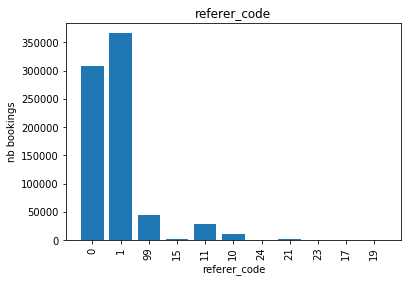

In [40]:
# referer_code
dict_referer_code, referer_code_list = get_nb_bookings_dict(train_user_df, 'referer_code')

plot_dict(dict_referer_code, 'referer_code', 'referer_code', 'nb bookings')